In [2]:
import numpy as np
import torch
dtype = torch.float
device = torch.device("cpu")
import matplotlib.pyplot as plt
plt.style.use('ggplot')

batch_size = 4
input_size = 2
hidden_size = 3
output_size = 1

## Реализация без Autograd

In [2]:
torch.manual_seed(777)
np.random.seed(777)

# Create random input and output data
x = torch.randn(batch_size, input_size, device=device, dtype=dtype)
y = torch.randn(batch_size, output_size, device=device, dtype=dtype)

# Randomly initialize weights
w1 = torch.randn(input_size, hidden_size, device=device, dtype=dtype)
w2 = torch.randn(hidden_size, output_size, device=device, dtype=dtype)

# добавляем bias
b1 = torch.randn(1, hidden_size, device=device, dtype=dtype)
b2 = torch.randn(1, output_size, device=device, dtype=dtype)

#добавляем переменные для сохранения градиентов
grad_noag_b1_1 = []
grad_noag_b1_2 = []
grad_noag_b1_3 = []
grad_noag_b2 = []
grad_noag_w2 = []
loss_hist_noag = []

#увеличим скорость обучения 
learning_rate = 1e-4
for t in range(500):
    # forward pass
    h1 = x.mm(w1) + b1
    # h1 = h1 = x.mm(w1)
    hrelu = h1.clamp(min=0)
    # y_pred = hrelu.mm(w2)
    out = hrelu.mm(w2) + b2
    
    # Compute and print loss
    loss = (out-y).pow(2).sum().item()
    loss_hist_noag.append(loss)
    
    # backward pass
    dloss_dout = 2 * (out - y)    
    grad_w2 = hrelu.t().mm(dloss_dout)
    grad_hrelu = dloss_dout.mm(w2.t())
    grad_hrelu[h1 < 0] = 0
    grad_w1 = x.t().mm(grad_hrelu)
    
    # градиенты для bias
    grad_b1 = grad_hrelu.sum(axis=0,keepdims=True)
    grad_b2 = dloss_dout.sum(axis=0,keepdims=True)

    grad_noag_b1_1.append(grad_b1[0][0].item())
    grad_noag_b1_2.append(grad_b1[0][1].item())
    grad_noag_b1_3.append(grad_b1[0][2].item())
    grad_noag_b2.append(grad_b2[0][0].item())
    grad_noag_w2.append(grad_w2[0][0].item())


    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2
    b1 -= learning_rate * grad_b1
    b2 -= learning_rate * grad_b2

    if t % 100 == 99:
        print('Loss on iteration {} = {}'.format(t, loss))

Loss on iteration 99 = 5.164945125579834
Loss on iteration 199 = 3.6529581546783447
Loss on iteration 299 = 2.9682865142822266
Loss on iteration 399 = 2.7711222171783447
Loss on iteration 499 = 2.6358067989349365


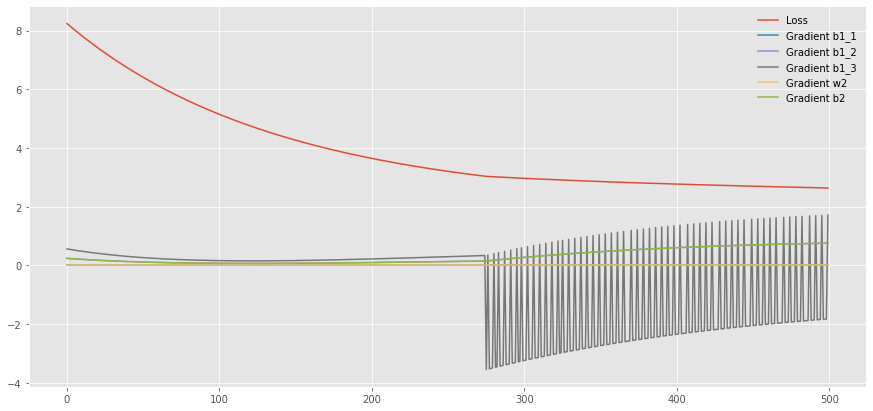

In [3]:
# Посмотрим на градиенты bias и ещё w2

plt.figure(figsize=(15,7))
plt.plot(loss_hist_noag, label = 'Loss')
plt.plot(grad_noag_b1_1, label = 'Gradient b1_1')
plt.plot(grad_noag_b1_2, label = 'Gradient b1_2')
plt.plot(grad_noag_b1_3, label = 'Gradient b1_3')
plt.plot(grad_noag_w2, label = 'Gradient w2')
plt.plot(grad_noag_b1_2, label = 'Gradient b2')
plt.legend(framealpha = 0)
plt.show()

## Реализация с Autograd

In [3]:
torch.manual_seed(777)
np.random.seed(777)

# Create random input and output data
x = torch.randn(batch_size, input_size, device=device, dtype=dtype)
y = torch.randn(batch_size, output_size, device=device, dtype=dtype)

# указываем, за какими векторами нужно сделить
w1 = torch.randn(input_size, hidden_size, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(hidden_size, output_size, device=device, dtype=dtype, requires_grad=True)

# добавляем bias
b1 = torch.randn(1, hidden_size, device=device, dtype=dtype, requires_grad=True)
b2 = torch.randn(1, output_size, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-4
#добавляем переменные для сохранения градиентов
grad_b1_1 = []
grad_b1_2 = []
grad_b1_3 = []
grad_b2 = []
grad_w2 = []
loss_hist_ag = []

for t in range(500):
    # добавляем bias в out
    y_pred = (x.mm(w1)+b1).clamp(min=0).mm(w2)+b2
    loss_ag = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss_ag.item())
    
    # Теперь подсчет градиентов для весов происходит при вызове backward
    loss_ag.backward()
    loss_hist_ag.append(loss_ag.item())

   
    # Обновляем значение весов, но укзаываем, чтобы PyTorch не считал эту операцию, 
    # которая бы учавствовала бы при подсчете градиентов в chain rule
    grad_b1_1.append(b1.grad[0].numpy()[0].copy())
    grad_b1_2.append(b1.grad[0].numpy()[1].copy())
    grad_b1_3.append(b1.grad[0].numpy()[2].copy())
    grad_b2.append(b2.grad[0].numpy().copy())
    grad_w2.append(w2.grad[0].numpy().copy())

    with torch.no_grad():

        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad
        b1 -= learning_rate * b1.grad
        b2 -= learning_rate * b2.grad

        w1.grad.zero_()
        w2.grad.zero_()
        b1.grad.zero_()
        b2.grad.zero_()

99 5.164945125579834
199 3.6529581546783447
299 2.9682865142822266
399 2.7711222171783447
499 2.6358067989349365


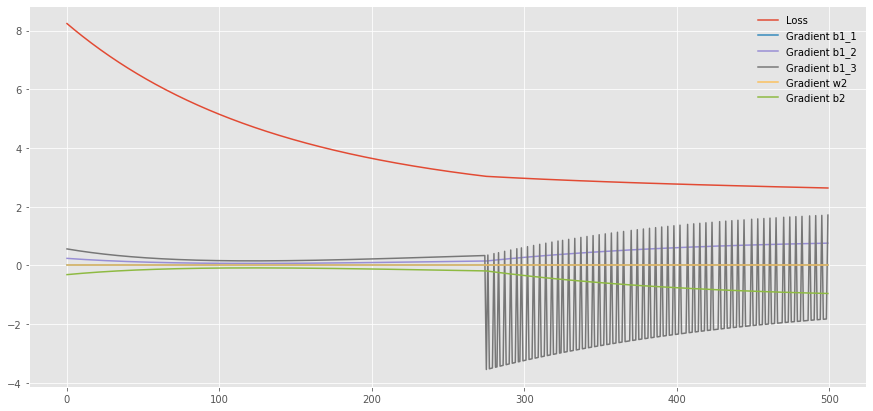

In [4]:
# графики для Autograd
plt.figure(figsize=(15,7))
plt.plot(loss_hist_ag, label = 'Loss')
plt.plot(grad_b1_1, label = 'Gradient b1_1')
plt.plot(grad_b1_2, label = 'Gradient b1_2')
plt.plot(grad_b1_3, label = 'Gradient b1_3')
plt.plot(grad_w2, label = 'Gradient w2')
plt.plot(grad_b2, label = 'Gradient b2')
plt.legend(framealpha = 0)
plt.show()

Осталось еще не вручную обновлять веса, а использовать адаптивные методы градинетного спсука. Для этого нужно использовать модуль __optim__. А помимо оптимайзера, еще можно использовать готовые целевые функции из модлуя __nn__.

In [5]:
import torch.optim as optim

torch.manual_seed(777)
np.random.seed(777)

# Create random input and output data
x = torch.randn(batch_size, input_size, device=device, dtype=dtype)
y = torch.randn(batch_size, output_size, device=device, dtype=dtype)

# указываем, за какими векторами нужно сделить
w1 = torch.randn(input_size, hidden_size, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(hidden_size, output_size, device=device, dtype=dtype, requires_grad=True)

# добавляем bias
b1 = torch.randn(1, hidden_size, device=device, dtype=dtype, requires_grad=True)
b2 = torch.randn(1, output_size, device=device, dtype=dtype, requires_grad=True)

#добавляем переменные для сохранения градиентов
grad_opt_b1_1 = []
grad_opt_b1_2 = []
grad_opt_b1_3 = []
grad_opt_b2 = []
grad_opt_w2 = []
loss_hist_opt = []

loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
optimizer = optim.Adam([w1, w2, b1, b2], lr=learning_rate)

for t in range(500):
    optimizer.zero_grad()
    
    y_pred = (x.mm(w1)+b1).clamp(min=0).mm(w2)+b2
    
    loss_opt = loss_fn(y_pred, y)
    with torch.no_grad():
        loss_hist_opt.append(loss_opt.detach().numpy())

    if t % 100 == 99:
        print(t, loss_opt.item())
    
    loss_opt.backward()

    grad_opt_b1_1.append(b1.grad[0].numpy()[0].copy())
    grad_opt_b1_2.append(b1.grad[0].numpy()[1].copy())
    grad_opt_b1_3.append(b1.grad[0].numpy()[2].copy())
    grad_opt_b2.append(b2.grad[0].numpy()[0].copy())
    grad_opt_w2.append(w2.grad[0].numpy()[0].copy())
   
    optimizer.step()

99 7.843573570251465
199 7.466870307922363
299 7.108004570007324
399 6.765708923339844
499 6.439129829406738


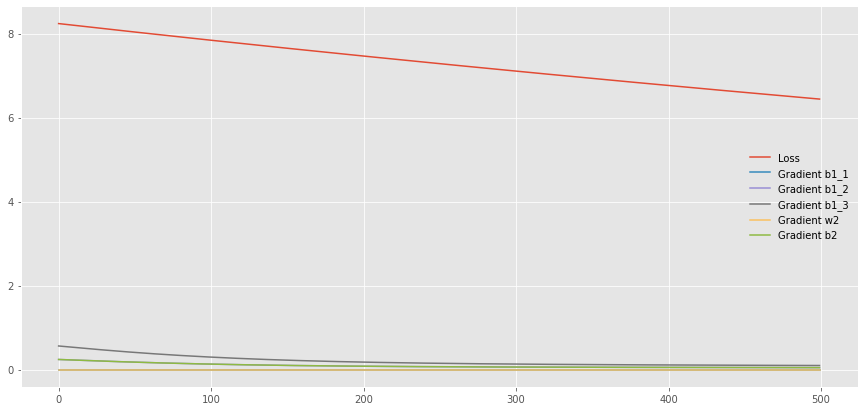

In [6]:
# Посмотрим на градиенты bias и ещё w2

plt.figure(figsize=(15,7))
plt.plot(loss_hist_opt, label = 'Loss')
plt.plot(grad_opt_b1_1, label = 'Gradient b1_1')
plt.plot(grad_opt_b1_2, label = 'Gradient b1_2')
plt.plot(grad_opt_b1_3, label = 'Gradient b1_3')
plt.plot(grad_opt_w2, label = 'Gradient w2')
plt.plot(grad_opt_b1_2, label = 'Gradient b2')
plt.legend(framealpha = 0)
plt.show()

# Домашнее задание

1. Добавить Bias и посчитать для них градиенты.
2. Сравнить градинеты с тем, как считает PyTorch AutoGrad.
    Ответ: градиенты оказались равными с точностью всех знаков после запятой. Градиент w2 всё обучение равен нулю.